
# PIT - Práctica 2: Modelos ocultos de Markov (HMM)

**Alicia Lozano Díez** y **Pablo Ramírez Hereza**

**Estudiante: Francisco Javier Sáez Maldonado**
 
21 de febrero de 2022

## Objetivos

Los objetivos de esta práctica son:
* Comprobación de las características de un HMM en función de sus parámetros.
* Resolución de los tres problemas asociados a un modelo oculto de Markov:
    * Cálculo de la verosimilitud de una secuencia de observaciones y un HMM mediante la implementación del algoritmo *Forward*.
    * Obtención de la secuencia de estados más probable dada una secuencia de observaciones mediante la implementación del algoritmo de *Viterbi*.
    * Entrenamiento de un HMM con *EM*, en concreto el algoritmo *Baum-Welch*.
* Utilización del paquete `hmmlearn` de `python` para la implementación de los algoritmos anteriores.
* Utilización de HMMs en un caso práctico de clasificación de patrones temporales.

## Materiales - Moodle
Los materiales proporcionados para esta práctica son:
- Guión (.ipynb) de la práctica
- Bases de datos para el ejercicio 3.
  - sin_averias.csv
  - fallo_componente.csv
  - uso_inapropiado.csv

In [1]:
import numpy as np
from hmmlearn import hmm
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

np.random.seed(234)

## PARTE 1: Introducción a los Modelos Ocultos de Markov (HMM)

### 1.1 Definición de un modelo oculto de Markov

Los modelos ocultos de Markov (*Hidden Markov Model* o *HMM*) es un modelo probabilístico generativo, en el cual una secuencia de variables observables $\mathrm{X}$ es generada por una secuencia de estados ocultos internos $\mathbf{\mathrm{Z}}$. Las transiciones entre estados se asume que siguen la forma de una cadena de Markov de primer orden, de tal forma que el estado en un instante determinado *t* solo depende del estado del modelo en el instante anterior *t-1*.

Un HMM se encuentra definido por:
* El número de estados del modelo $N$.
* Probabilidades iniciales de ocupación de cada estado $\pi$.
* Matriz de probabilidades de transición entre estados $\mathbf{A}$.
* Distribución de probabilidad de observación de cada estado $\mathbf{B}$.

**a. Dibuje el diagrama de estados correspondiente al HMM definido por los parámetros descritos a continuación:**

`Nota:` Incluir el diagrama en una imagen en la entrega o en el informe de la práctica.

* Número de estados, $N=4$.
* Probabilidades iniciales de ocupación de cada estado:
$$
\pi = [0.4\; 0.3\; 0.2\; 0.1]
$$.
* Matriz de probabilidades de transición: 
$$A=\begin{bmatrix}
0.75 & 0.1 & 0.05 & 0.1 \\ 
0.1 & 0.75 & 0.1 & 0.05 \\ 
0.05 & 0.1 & 0.75 & 0.1\\ 
0.1 & 0.05 & 0.1 & 0.75
\end{bmatrix}
$$

* Cada estado tiene una distribución de observación (o distribución de emisión) Gaussiana bivariada. Cada Gaussiana se encuentra caracterizada por los siguientes parámetros:

  - $\mathbf{B}_1$:
$$
\mu_1 = [-1,\;0]
\;;\; \Sigma_1 = \mathcal{I}*4
$$.

  - $\mathbf{B}_2$:
$$
\mu_1 = [5,\;-1]
\;;\; \Sigma_1 = \mathcal{I}
$$.

  - $\mathbf{B}_3$:
$$
\mu_1 = [4,\;7.5]
\;;\; \Sigma_1 = \begin{bmatrix}
5.0 & -2.0\\ 
-2.0 & 3.0 
\end{bmatrix}
$$.

  - $\mathbf{B}_4$:
$$
\mu_1 = [-7.5,\;0]
\;;\; \Sigma_1 = \begin{bmatrix}
1.0 & 0.0\\ 
0.0 & 4.0 
\end{bmatrix}
$$

**`Nota`**: Haga uso de la clase `GaussianHMM` de `hmmlearn` para la implementación de este modelo.

**b.) Inicialice el HMM anterior mediante el uso de la clase ``hmmlearn.GaussianHMM``.**

El paquete `hmmlearn` [https://hmmlearn.readthedocs.io/en/latest/api.html] es un paquete de software libre desarrollado mediante el uso de scikit-learn, Numpy y matplotlib para el desarrollo e implementacion de los algoritmos destinados al entrenamiento, inferencia y muestreo de diferentes tipos modelos ocultos de Markov (HMM).

**ANTES DE IMPLEMENTAR**, nos damos cuenta de que vamos a implementar más de un HMM con con diferentes parámetros iniciales. Por ello, creamos la siguiente función que nos permite generar un HMM de cualquiera de los **tipos** proporcionados por `hmmlearn`.

In [8]:

def create_HMM_model(hmm_type,
                     n_components,
                     pi = None,
                     A = None, 
                     mu = None, 
                     Sigma = None,
                     gmmhmm_weights = None,
                     covariance_type = 'full'):
    """
    Creates HMM model for any type of distributions using the parameters given
    """
    
    # Create HMM with n_components
    model = hmm_type(n_components = n_components, covariance_type =covariance_type)
    # Fix transition matrix and prior distribution
    model.startprob_ = pi
    model.transmat_ = A
    # Fix means and covariances
    model.means_ = mu
    model.covars_ = Sigma
    
    # Specifies the dimension of the gaussians in the gaussian case
    if hmm_type == hmm.GaussianHMM:
        model.n_features = mu.shape[1]
    elif hmm_type == hmm.GMMHMM:
        model.weights_ = gmmhmm_weights
        
    
    return model

In [9]:
# Definición de las variables
# Número de estados
N = 4

# Matriz de Probabilidad de Transicion
A = np.array([[0.75, 0.1, 0.05, 0.1],
              [0.1, 0.75, 0.1 ,0.05],
              [0.05, 0.1, 0.75 ,0.1],
              [0.1, 0.05, 0.1 ,0.75]])

# Probabilidades iniciales de estado
pi = np.array([0.4, 0.3, 0.2, 0.1])


# Vectores de medias
mu = np.array([[-1.0, 0.0], [5.0, -1.0], [4, 7.5],[-7.5, 0.0]])

# Matrices de covarianza
Sigma = []
Sigma.append(np.identity(2)*4)
Sigma.append(np.identity(2))
Sigma.append(np.array([[5.0, -2], [-2, 3.0]]))
Sigma.append(np.array([[1.0, 0.0], [0.0, 4.0]]))
Sigma = np.array(Sigma)


HMM = create_HMM_model(hmm.GaussianHMM,N,pi, A, mu, Sigma,covariance_type = 'full')

**c.) Represente mediante curvas de contorno (función ``contour`` de pyplot) las distribuciones de probabilidad de observación de cada estado. Para la evaluación de la distribución de probabilidad en el plano de variables utilice la clase ``scipy.stats.multivariate_normal``.**

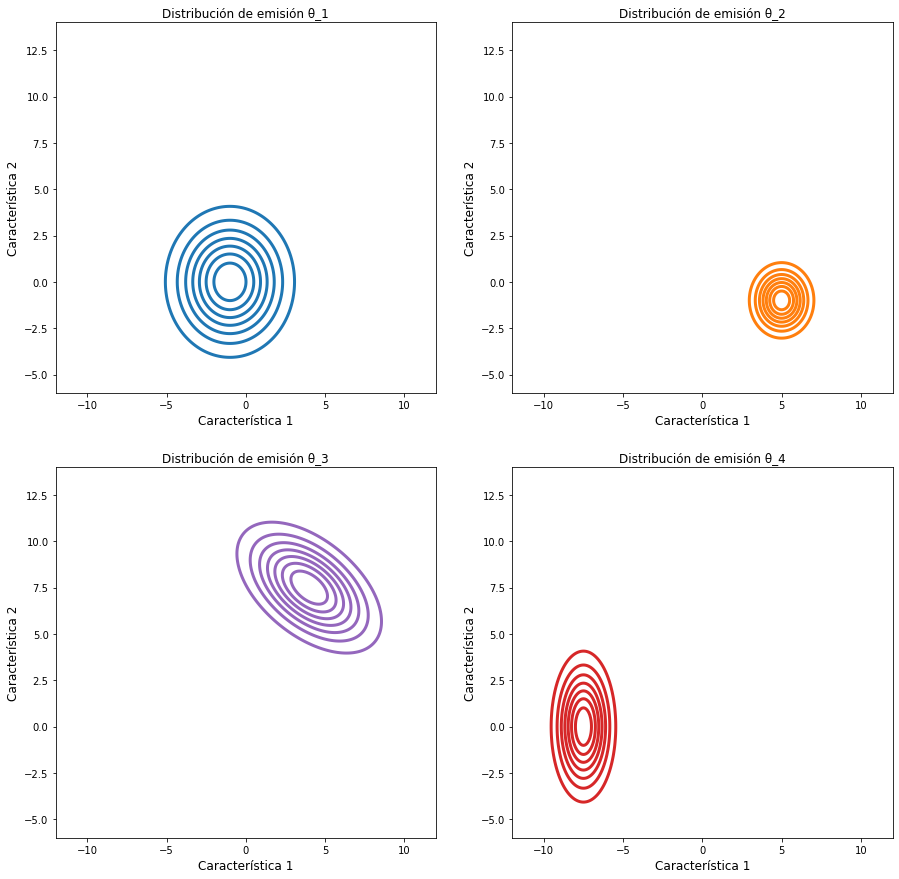

In [10]:
# Representación de las distribuciones de emisión para cada estado
# Definición de los ejes
x_axis = np.linspace(-12,12,300)
y_axis = np.linspace(-6,14,300)

# Generación de matrices con los ejes
_X, _Y = np.meshgrid(x_axis, y_axis)
# Agrupamiento por pares
positions = np.vstack([_X.ravel(), _Y.ravel()]).T

colors = ['tab:blue','tab:orange','tab:purple','tab:red']


# Generación de la figura
fig, ax = plt.subplots(2,2,figsize=(15, 15))
ax = ax.ravel()

for n in range(N):
    
    # Evaluación de cada una de las componentes gaussianas en los ejes
    eval_multivariate_normal = multivariate_normal.pdf(positions,HMM.means_[n],HMM.covars_[n])

    prob = np.reshape(eval_multivariate_normal, _X.shape)
    # Representación del contorno
    ax[n].contour(x_axis, y_axis, prob, colors=colors[n],linewidths=3)
        
    # Etiquetas y título
    ax[n].set_xlabel('Característica 1', fontsize=12)
    ax[n].set_ylabel('Característica 2', fontsize=12)
    ax[n].set_title('Distribución de emisión \u03B8_{:.0f}'.format(n+1) )

plt.show();

### 1.2 Proceso de generación de una secuencia 
Vamos a hacer uso de un dataset sintético generado exclusivamente para su utilización en esta sesión de prácticas. Para la generación de esta base de datos hemos inicializado en el apartado anterior un modelo oculto de markov haciendo uso del paquete `hmmlearn`. Una vez inicializado el modelo, en este apartado vamos a aplicar el proceso de generación de secuencias para extraer muestras del modelo generativo.

**a.) Utilice la función `gaussianHMM.sample` para generar una secuencia de 4000 muestras del HMM.**

In [11]:
# Número de muestras de la secuencia
T = 4000
# TO DO: utilizar gaussianHMM.sample para generar la base de datos.
# X: np.array NxD -> Secuencia de observaciones
# Z: np.array Nx1 -> Estados ocultos
X, Z = HMM.sample(T)

**b.) Represente las primeras `T_repr=50` muestras generadas mediante un scatter plot. Adicionalmente, con el objetivo de visualizar el caracter secuencial de los datos, represente cada una de las muestras unidas con líneas.**

**A partir de la representación, la matriz de probabilidades de transición y los estados ocultos generados, analice el comportamiento del modelo.**

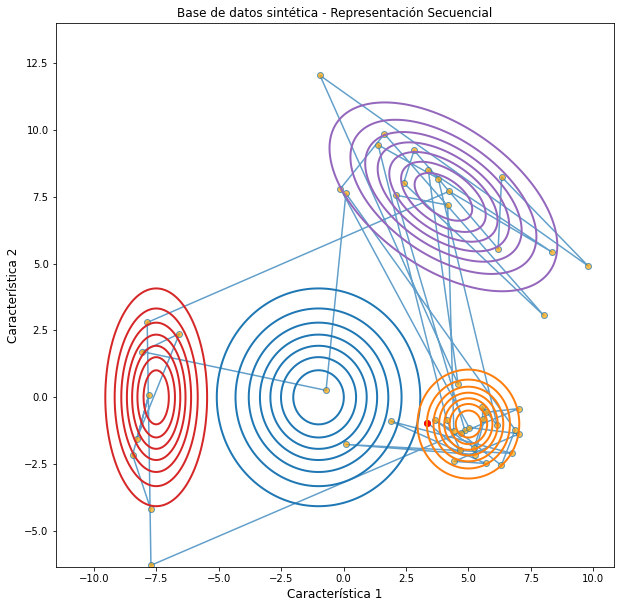

In [12]:
T_repr=50

# Representación de los datos mediante un scatter plot
fig,ax = plt.subplots(figsize=(10,10))

# Representación de los datos mediante un scatter plot
# Para mostrar el desarrollo de la secuencia
ax.plot(X[:T_repr,0],X[:T_repr,1],'o-',label='observations',mfc='orange',alpha=0.7)
ax.plot(X[0:1,0],X[0:1,1],'or')
plt.xlim((np.min(X[:,0]),np.max(X[:,0])))
plt.ylim((np.min(X[:,1]),np.max(X[:,1])))
ax.set_xlabel('Característica 1', fontsize=12)
ax.set_ylabel('Característica 2', fontsize=12)
ax.set_title('Base de datos sintética - Representación Secuencial' )

for n in range(N):
    #  TO DO: Evaluación de cada una de las componentes gaussianas en los ejes
    # y representación de los contornos
    eval_multivariate_normal = multivariate_normal.pdf(positions,HMM.means_[n],HMM.covars_[n])
    prob = np.reshape(eval_multivariate_normal, _X.shape)
    
    ax.contour(x_axis, y_axis, prob, colors=colors[n],linewidths=2)

    

plt.show();

A raíz de los resultados obtenidos, podemos ver que la simulación es acertada en sus primeras $50$ muestras. Si nos fijamos en la matriz de transiciones, vemos que estando en cada uno de los estados, es **mucho más probable quedarse en el mismo estado** que saltar a un estado diferente. Esto es justo lo que ocurre en nuestro gráfico, pues podemos ver que la mayoría de los puntos unidos (representando un salto en cada ocasión), se encuentran dentro de *la misma gaussiana*, representando cada una de ellas a uno de esos estados. Los saltos entre diferentes regiones coloreadas suceden en un número muy pequeño de ocasiones (podemos contar aproximadamente menos de $10$ en los 50 puntos representados), como nos sugería la matriz $A$ de transiciones.

### 1.3 Comparativa con otros modelos ocutos de Markov.

En este apartado se propone la definición de dos modelos alternativos al generado anteriormente.

**a.) Repita los apartados del ejercicio 1.1 y 1.2 con el modelo `HMM2` definido por los parámetros que se representan a continuación:**

NOTA: Incluir una imagen representando el diagrama de estados en el informe de la práctica. 

* Número de estados, $N=4$.
* Probabilidades iniciales de estado:

$$
\pi = [0.4\; 0.3\; 0.2\; 0.1]
$$.

* Matriz de probabilidades de transición: 
$$A=\begin{bmatrix}
0.75 & 0.1 & 0.05 & 0.1 \\ 
0.1 & 0.75 & 0.1 & 0.05 \\ 
0.05 & 0.1 & 0.75 & 0.1\\ 
0.1 & 0.05 & 0.1 & 0.75
\end{bmatrix}
$$

* Cada estado dispone de un Modelo de Mezclas de Gaussianas (GMM) bivariado como distribuciones de probabilidad de observación. Cada GMM se encuentra caracterizado por: 

  - $\mathbf{B}_1$:
$$
\pi_1 = [0.3\; 0.3\; 0.4]\;;\; \mu_1 = \begin{bmatrix}
-2.0 & 2.0\\ 
0.0 & -1.0\\ 
-3.0 & 1.0 
\end{bmatrix}\;;\; \Sigma_1 = \mathcal{I}
$$.

  - $\mathbf{B}_2$:
$$
\pi_2 = [0.2\; 0.5\; 0.3]\;;\; \mu_2 = \begin{bmatrix}
5.0 & -1.0\\ 
5.0 &  1.0\\ 
6.0 & -1.0
\end{bmatrix}\;;\; \Sigma_2 = \mathcal{I}
$$.

  - $\mathbf{B}_3$:
$$
\pi_3 = [0.4\; 0.3\; 0.3]\;;\; \mu_3 = \begin{bmatrix}
3.0 & -5.0\\ 
1.0 &  10.0\\ 
5.0 & 8.0
\end{bmatrix}\;;\; \Sigma_3 = \mathcal{I}
$$.

  - $\mathbf{B}_4$:
$$
\pi_1 = [0.5\; 0.3\; 0.2]\;;\; \mu_1 = \begin{bmatrix}
-8.0 & -0.0\\ 
-8.0 &  2.0\\ 
-8.0 &  -2.0
\end{bmatrix}\;;\; \Sigma_1 = \mathcal{I}
$$.

**¿Qué tipo de HMM es según su topología?¿En qué difieren los modelos `HMM1` y `HMM2`?**

ValueError: Array 'mean' must be a vector of length 6.

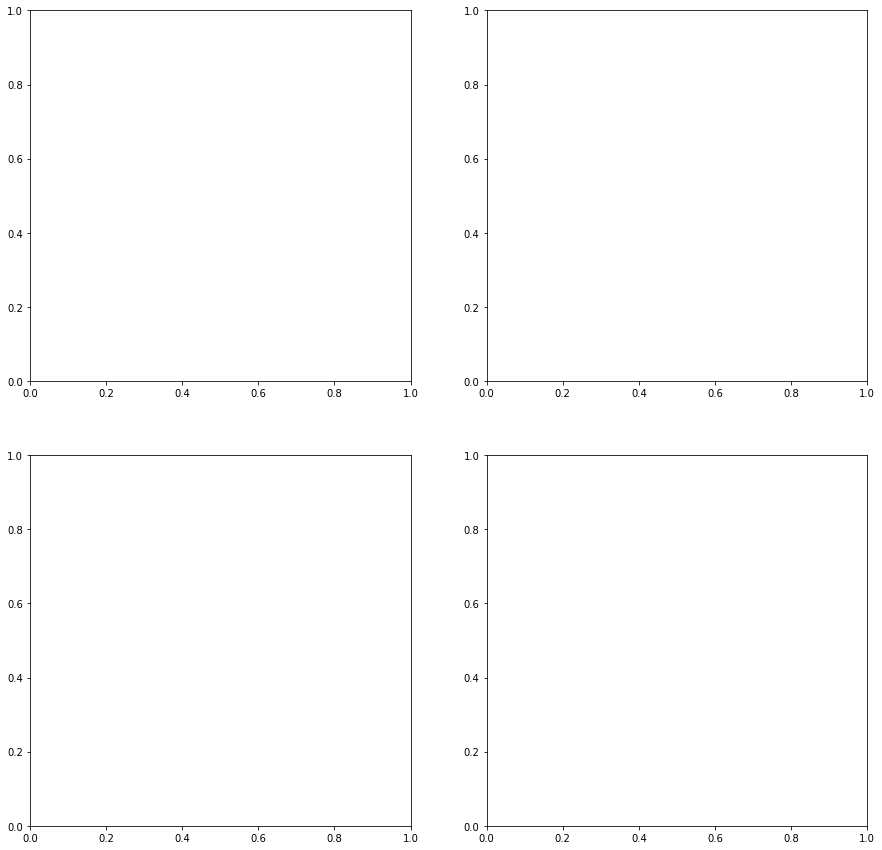

In [17]:
# Distribuciones de Probabilidad de emisión: GMM para cada estado
# Numero de componentes gaussianas
n_gaussians = 3

# 1) Pesos de las componentes gaussianas de las GMM
# pesos_{i,j} corresponde al peso de la componente j del estado i ''
weights2 = np.array([[0.3, 0.3, 0.4],
                  [0.2, 0.5, 0.3],
                  [0.4, 0.3, 0.3],
                  [0.5, 0.3, 0.2]])

# 2) Vectores de medias de las componentes gaussianas de las GMM
# mu_{i,j} corresponde al vector de medias de la componente j del estado i (vector 2D)
mu2 = np.array([[[-2.0, 2.0], [0.0, -1], [-3.0, 1.0]],
               [[5.0, 0.0], [5.0, -1.0], [6.0, -1.0]],
               [[3.0, 5.0], [1.0, 10], [5.0, 8.0]],
               [[-8.0, 0.0], [-8.0, 2], [-8.0, -2.0]]])


#3) Matrices de covarianza de las componentes Gaussianas de las GMM
# sigma_{i,j} corresponde a la matriz de covarianzas de la componente j del estado i (vector 2D)
sigma2 = np.tile(np.identity(2), (4, 3, 1, 1))

# Inicialización del modelo:
HMM2 = create_HMM_model(hmm.GMMHMM,
                        n_gaussians,
                        pi = pi,
                        A = A, 
                        mu = mu2,
                        Sigma = sigma2,
                        gmmhmm_weights = weights2,
                        covariance_type = 'full')


######################################################################### 1.1C
# Representación de las distribuciones de emisión para cada estado
# Definición de los ejes
x_axis = np.linspace(-12,12,300)
y_axis = np.linspace(-6,14,300)

# Generación de matrices con los ejes
_X, _Y = np.meshgrid(x_axis, y_axis)
# Agrupamiento por pares
positions = np.vstack([_X.ravel(), _Y.ravel()]).T

colors = ['tab:blue','tab:orange','tab:purple','tab:red']

# Generación de la figura
fig, ax = plt.subplots(2,2,figsize=(15, 15))

ax = ax.ravel()
for n in range(N):
    
    for g in range(n_gaussians):
        # TO DO: Evaluación de cada una de las componentes gaussianas en los ejes
        eval_multivariate_gaussian= multivariate_normal.pdf(positions,HMM2.means_[n],HMM2.covars_[n])
        prob = np.reshape(eval_multivariate_gaussian, _X.shape)
        # Representación del contorno
        ax[n].contour(x_axis, y_axis, prob, colors=colors[g],linewidths=3)
        # Etiquetas y título
        ax[n].set_xlabel('Característica 1', fontsize=12)
        ax[n].set_ylabel('Característica 2', fontsize=12)
        ax[n].set_title('Distribución de emisión \u03B8_{:.0f}'.format(n+1) )

plt.show();

######################################################################### 1.2
X2, Z2 = HMM2.sample(T)

T_repr=50

# Representación de los datos mediante un scatter plot
fig2,ax2 = plt.subplots(figsize=(10,10))

# Representación de los datos mediante un scatter plot
# Para mostrar el desarrollo de la secuencia
ax2.plot(X2[:T_repr,0],X2[:T_repr,1],'o-',label='observations',mfc='orange',alpha=0.7)
ax2.plot(X2[0:1,0],X2[0:1,1],'or')
plt.xlim((np.min(X2[:,0]),np.max(X2[:,0])))
plt.ylim((np.min(X2[:,1]),np.max(X2[:,1])))
ax2.set_xlabel('Característica 1', fontsize=12)
ax2.set_ylabel('Característica 2', fontsize=12)
ax2.set_title('Base de datos sintética - Representación Secuencial' )


for n in range(N):
  for g in range(n_gaussians):
    # TO DO: Evaluación de cada una de las componentes gaussianas en los ejes
    eval_multivariate_gaussian= multivariate_normal.pdf(positions,HMM2.means_[n],HMM2.covars_[n])
    prob = np.reshape(eval_multivariate_gaussian, _X.shape)
    ax2.contour(x_axis, y_axis, prob,colors=colors[n],linewidths=3)


**b) Repetir los apartados del ejercicio 1.1 y 1.2 utilizando un modelo `HMM3` que se diferencia del modelo `HMM1` en la matriz de probabilidades de transición y las probabilidades iniciales de estado:**

$$A=\begin{bmatrix}
0.7 & 0.15 & 0.15 & 0 \\ 
0 & 0.8 & 0.15 & 0.05 \\ 
0 & 0 & 0.9 & 0.1\\ 
0 & 0 & 0 & 1
\end{bmatrix}
$$

$$
\pi = [0.9\; 0.1\; 0.0\; 0.0]
$$

**`Nota`**: Las secuencias X y Z generadas tras el muestreo de `HMM3` se guardarán en las variables X3 y Z3, para no sobreescribir las secuencias ya generadas.


**¿Qué tipo de HMM es según su topología?¿En qué difieren los modelos `HMM1` y `HMM2`?**


In [ ]:
# Guardamos el modelo anterior con el nombre HMM1
import copy


# TO DO: Definición Matriz de Probabilidad de Transicion
A3 = ... 
# TO DO: Definición
pi3 = ...

# TO DO: Definición del modelo HMM3
HMM3 = ...

# Apartado c)

# Generación de la figura
fig, ax = plt.subplots(2,2,figsize=(15, 15))
ax = ax.ravel()

for n in range(N):
    
    # TO DO: Evaluación de cada una de las componentes gaussianas en los ejes
    eval_multivariate_gaussian =...
    prob = np.reshape(eval_multivariate_gaussian, _X.shape)
    # Representación del contorno
    ax[n].contour(x_axis, y_axis, prob, colors=colors[n],linewidths=3)
        
    # Etiquetas y título
    ax[n].set_xlabel('Característica 1', fontsize=12)
    ax[n].set_ylabel('Característica 2', fontsize=12)
    ax[n].set_title('Distribución de emisión \u03B8_{:.0f}'.format(n+1) )

# Apartado d)
# Muestreo ancestral -> Atributo .sample
# X: np.array NxD -> Secuencia de observaciones
# Z: np.array Nx1 -> Estados ocultos
X3, Z3 = HMM3.sample(T)


# Apartado e)
# Representación de los datos mediante un scatter plot
fig,ax = plt.subplots(figsize=(10,10))

# Representación de los datos mediante un scatter plot
# Para mostrar el desarrollo de la secuencia
ax.plot(X3[:T_repr,0],X3[:T_repr,1],'.-',label='observations',mfc='orange',alpha=0.7)
ax.plot(X3[0:1,0],X3[0:1,1],'o-r')
plt.xlim((np.min(X3[:,0]),np.max(X3[:,0])))
plt.ylim((np.min(X3[:,1]),np.max(X3[:,1])))
ax.set_xlabel('Característica 1', fontsize=12)
ax.set_ylabel('Característica 2', fontsize=12)
ax.set_title('Base de datos sintética - Representación Secuencial' )

for n in range(N):
    # Evaluación de cada una de las componentes gaussianas en los ejes
    eval_multivariate_gaussian=...
    prob = np.reshape(eval_multivariate_gaussian, _X.shape)
    # Representación del contorno
    ax.contour(x_axis, y_axis, prob, colors=colors[n],linewidths=3)

## Parte 2: Problemas clásicos de los modelos ocultos de Markov.

### 2.1: Problema de puntuación

Dado el modelo $\lambda = (A,  \mathbf{B}, \pi)$ y un conjunto de observaciones $\mathrm{X}= \{ \mathrm{x}_1, ..., \mathrm{x}_N \}$ el cálculo de $P(X|\lambda)$ o la verosimilitud del modelo $\lambda$ con los datos $\mathrm{X}$ se realiza mediante el algoritmo *Forward*.

Este algoritmo queda descrito por el siguiente pseudocodigo:

___________________________________________
**Algoritmo Forward**
Entrada: $ \boldsymbol{X}, A, \mathbf{B}, \pi$
___________________________________________
- $[\phi_1] = \text{Eval_Px_z}(X_1, \mathbf{B})$
- $[\alpha_1, C_1] = \text{Normalize}(\phi_1\odot\pi)$

- **for** $t=2:N$ **do**:
  - $[\phi_t] = \text{Eval_Px_z}(X_t, \mathbf{B})$
  - $[\alpha_t, C_t] = \text{Normalize}(\phi_t \odot (A^T\alpha_{t-1}))$

- **Return** $\alpha_{1:N}$, $\log P(X_{1:N}) = \sum_t \log C_t$



In [ ]:
####################################################################################
# Función Normalize
# Descripción: Función para la normalización de un vector. Se va a utilizar para el calculo
# de las probabilidades a posteriori del estado P(Z|X) = P(X,Z)/P(X) 
#
# Entradas:
#   u: np.array Kx1 correspondiente a P(X|Z)
# Salidas:
#   C: 1x1 P(X) probabilidad marginal de la secuencia de observaciones (marginalizando los estados)
#   alfa: Kx1 P(Z|X) probabilidades a posteriori de cada estado
####################################################################################
def Normalize(u):
    C = np.sum(u)
    alfa = u/C
    
    return C,alfa

**a.) Complete la función Eval_Px_z para calcular la probabilidad de observación dado cada un estado para el modelo `HMM1` en el que la probabilidad de observación de cada estado viene definida por una distribución Gaussiana bivariada.**

**Compruebe su funcionamiento con la primera muestra de nuestra base de datos X**

In [ ]:
####################################################################################
# Función eval_Px_Z
# Descripción: Función para la obtención de P(X|Z). Evaluación de X en cada uno de 
# las gaussianas (estados)
#
# Entradas:
#   data: np.array NxK secuencia de observaciones de entrada
#   B: Lista con las Gaussianas de cada estado. Lista de elementos clase multivariate_normal
# Salidas:
#    result: P(X|Z) : Probabilidad devuelta por el Gaussiana de cada estado
####################################################################################
def eval_Px_Z(data,B):

    fi = np.empty((len(B),1))
    for k,g in enumerate(B):
        # TO DO: Evaluación del la probabilidad de observación Gaussiana para la muestra
        fi[k] = ...
        # Se agrupan en una lista todas las probabilidades devueltas por cada estado
        # Se calcula la exponencial para obtener un valor de probabilidad.
    return fi


In [ ]:
# Se almacenan las Gaussianas de cada estado en una lista.
# Al no ser entrenadas, necesitan la definición de todos sus parámetros.
B = []
for n in range(N):
    Gaussian_states = multivariate_normal(mean=mu[n], cov=Sigma[n])
    B.append(Gaussian_states)

# TO DO: LLamada a la función eval_Px_Z
fi= ...

# TO DO: Devolver X[0], P(X[0]|lambda)

**b.) A partir del pseudocódigo del enunciado, complete la función Forward que realiza el proceso completo para el cálculo de la verosimilitud de una secuencia $\boldsymbol{X}$ dado el HMM del primer ejercicio.** 

**Analice la función Forward ¿Qué representan los parámetros $\phi$, $\alpha$ y $C$?**

In [ ]:
####################################################################################
# Función Forward
# Descripción: Implementa el algoritmo forward para la obtención de P(X|HMM)
#
# Entradas:
#   data: np.array NxK secuencia de observaciones de entrada
#   A:    np.array KxK Matriz de probabilidades de transición
#   pi:   np.list Kx1 Probabilidades de estado iniciales
#   B: Lista con los parámetros de los GMMs de cada estado
# Salidas:
#    log_likelihood: Logaritmo de la verosimilitud P(X\HMM)
####################################################################################
def Forward(data,A,pi,B):
    # Inicialización de las variables: logaritmo de la verosimilitd
    # alpha: Matriz en la que se van a almacenar las P(Z|X)
    log_likelihood = 0
    alpha= np.zeros((len(B),np.size(data,0)))
    
    # 1) Primera muestra
    pi = pi.reshape((len(B),1))
    # TODO Calcular fi P(X_i|Z) sin normalizar
    fi = ...

    # TODO calcular alfa P(X_i|Z) y C P(X_i)
    C,alfa =  ...

    # Almacenamiento de las prob
    alpha[:,0]=alfa.ravel()
    
    # TO DO: Calculo del logaritmo de la probabilidad para la primera muestra
    log_likelihood = ... 
    
    # 2) Para el resto de las muestras 
    for i in range(1,np.size(data,0)):

        # 2.1 TO DO:  Calculo de fi 
        fi = ...
        # 2.2 TO DO:calculo de alfa en el instante t dado alfa en t-1
        C,alfa = ...

        alpha[:,i]=alfa.ravel()
        # 2.3 TO DO: Se suma el logaritmo de la probabilidad marginal
        log_likelihood= ...
    return log_likelihood

In [ ]:
# LLamada a la función Forward -> Devuelve el logaritmo de la verosimilitud 
loglikelihood= Forward(data=X,A=A,pi=pi,B=B)
print('El logaritmo de la verosimilitud del modelo con la secuencia de observaciones X P(X|\u03BB) es {:.4f}'.format(loglikelihood))

**b.) Compruebe el resultado obtenido en el apartado anterior con el resultado al aplicar la función de `hmmlearn` (método `.score`) para el cálculo de la verosimilitud mediante el algoritmo *Forward*.**

In [ ]:
# TO DO: Implementación del algoritmo Forward en el atributo .score del HMM
loglikelihood = ... 

print('El logaritmo de la verosimilitud del modelo con la secuencia de observaciones X P(X|\u03BB) es {:.4f}'.format(loglikelihood))

**c.) ¿Cuál de los tres modelos `HMM`, `HMM2` y `HMM3` maximiza el logaritmo de la verosimilitud? ¿Es este resultado el esperado? Justifique su respuesta.**

**`Nota`**: Utilice para ello la función `Forward` implementada anteriormente o la función disponible en `hmmlearn`.


### 2.1: Problema de reconocimiento de estados

Dado una secuencia de observaciones $X = \{\mathrm{x}_1,...,\mathrm{x}_N\}$ y un modelo $\lambda = (\pi, A, \mathbf{B})$ el algoritmo de *viterbi* permite encontrar la secuencia de estados ocultos más probable , es decir, permite obtener la secuencia de estados que mejor ''explica'' las observaciones.

El algoritmo de viterbi queda descrito por el siguiente pseudocódigo:

_________________________________________________________
**Algoritmo de Viterbi** Entrada: $\boldsymbol{X}$, $A$, $\pi$, $\mathbf{B}$
_________________________________________________________
- $a_1=\boldsymbol{0}$
- $\phi_1 = \text{eval_Px_Z}(X_1,\mathbf{B})$
- $\delta = \pi \odot \phi_1$
- **for** $t=2:T$ **do**:
  - **for** $j = 1:N$ **do**:
  - $\phi_t = \text{eval_Px_Z}(X_t,\mathbf{B})$
  - $[a_t(j), \delta_t(j)] =\text{max}_i(\text{log}\delta_{t-1}(:) + \text{log}A_{ij} +\text{log}\phi_t(j))$ 

- $S_T = \text{arg}\text{max}(\delta_T)$
- **for** $t = N-1:1$ **do**
  - $S_t = a_{t-1}S_{t+1}$

- **Return** S


**a.) Complete la función `viterbi` para que integre el algoritmo de viterbi para la decodificación de la secuencia más probable de estados dada una secuencia de observaciones.**

**Describa brevemente el significado de cada una de las variables del algoritmo y compruebe la secuencia resultante con los estados obtenidos al generar la base de datos.**

In [ ]:
# %% Implementación del algoritmo de Viterbi:
import warnings
warnings.filterwarnings('ignore')

####################################################################################
# Función Viterbi
# Descripción: Implementa el algoritmo de viterbi para la generación de la secuencia
# de estados más probable dado un conjunto de observaciones y un modelo
#
# Entradas:
#   data: np.array NxK secuencia de observaciones de entrada
#   A:    np.array KxK Matriz de probabilidades de transición
#   pi:   np.list Kx1 Probabilidades de estado iniciales
#   B: Lista con los parámetros de los GMMs de cada estado
# Salidas:
#    S:  np.array Nx1 con la secuencia de estados más probable
####################################################################################
def viterbi(data,A,B,pi):
    # Inicialización de Matriz en la que vamos a ir guardando los estados más probables
    a = np.zeros((np.size(A,0),np.size(data,0)-1))
    # Inicialización en la que se van a ir guardando las mejores puntuaciones
    omega = np.zeros((np.size(A,0),np.size(data,0)))
    
    # 1) Incializacion Primera muestra
    pi = pi.reshape((len(B),1))
    fi = eval_Px_Z(data[0,:],B)
    omega[:,0] = np.log((pi*fi).ravel())
    
    # 2) Recursión
    for t in range(1,np.size(data,0)):
        for k in range(len(B)):

            # TO DO: Calculo de P(X|Z)
            fi= 

            # TO DO: calculo del logaritmo de las puntuaciones
            prob = ...

            # TO DO: Calculo de la probabilidad máxima
            omega[k,t] = ...
            # TO DO: Calculo del estado anterior más probable
            a[k,t-1] = ...
    
    # Array con la secuencia de estados final
    S=np.zeros(np.size(data,0))
    
    # 3) Terminación 
    ultimo_estado = np.argmax(omega[:,-1:])
    S[0] = ultimo_estado
        
    # 4) Path Backtracking
    indice_back = 1
    for i in range(np.size(data,0)-2,-1,-1):
        S[indice_back] = a[int(ultimo_estado),i]
        ultimo_estado = S[indice_back]
        indice_back +=1
    
    S = np.flip(S,axis=0)
    return S


In [ ]:
# TO DO: LLamada a viterbi 
SeqViterbi = ...
print("La secuencia de estados ocultos más probable es ",SeqViterbi)

**b.) Haga uso de la función `.decode` de ``hmmlearn`` para la implementación del algoritmo viterbi para la decodificación de la secuencia más probable de estados dada una secuencia de observaciones. ¿Coincide la secuencia con la devuelta por la función previamente implementada?**

In [ ]:
# TO DO: Implementacion de viterbi mediante .decode(algorithm='viterbi')

### 2.3: Problema de entrenamiento

Dado un conjunto de observaciones $X=\{\mathrm{x}_1,...,\mathrm{x}_N\}$ el cálculo de los parámetros que definen el modelo oculto de markov $\lambda = \left( \pi, A, \mathbf{B}\right)$ que maximizan la verosimilitud de los datos dado el modelo $P(X|\lambda)$ se obtiene mediante el algoritmo EM o, en este caso, el algoritmo *Baum-Welch*.

**a) Utilice la función `.fit` para entrenar un modelo oculto de markov a partir de los datos sintéticos generados en el ejercicio 1.**

**Analice los parámetros obtenidos y compárelos con el modelo generador de los datos. ¿Qué ocurre con el parámetro de los estados iniciales?**

In [ ]:
# TO DO: Utilización de .fit para el entrenamiento de la clase Gaussian HMM
model_trained = ...



**b.) Realice el entrenamiento del modelo utilizando varias secuencias generadas sintéticamente a partir del muestreo ancestral del primer modelo. Compare los parámetros del modelo aprendido con el primer modelo.**

In [ ]:
# Supongamos que tenemos diferentes secuencias de entrenamiento
X1,Z1 = HMM.sample(4000)
X2,Z2 = HMM.sample(4000)
X3,Z3 = HMM.sample(4000)
X4,Z4 = HMM.sample(4000)
X5,Z5 = HMM.sample(4000)

# Concatenamos todas las secuencias que tenemos
X_total = np.concatenate([X,X1,X2,X3,X4,X5],axis=0)
# Determinamos la longitud de cada cadena
lengths = np.array([len(X),len(X1), len(X2), len(X3),len(X4), len(X5)])

# TO DO: Utilización de .fit para el entrenamiento de la clase Gaussian HMM
model_trained = ...


## Parte 3: Clasificación de patrones temporales mediante HMMs

**Caso Ficticio**: Una empresa dedicada al suministro y gestión de maquinaria industrial desea identificar si las averías presentes en sus equipos se deben a un fallo en un componente o debido a un uso indebido de los mismos. Esto es considerado una tarea clave para la empresa, pues en el caso de que las averías se debiesen a un fallo debido a su incorrecto uso, serían los usuarios los responsables de financiar el arreglo.

Para ello, el personal técnico decide instalar determinados sensores para medir la vibración y la velocidad de funcionamiento de las máquinas. Tras varios meses de funcionamiento, los sensores capturan secuencias de ambas medidas normalizadas en diferentes circunstancias.

De esta forma, se recogen 10 secuencias asociadas a averías debido al fallo de un componente, 10 secuencias asociadas a averías debido a su uso indebido y, por último, 10 secuencias en las que el equipo no presenta avería alguna.

Las medidas se pueden encontrar en los ficheros "uso_inapropiado.csv", "fallo_componente.csv" y "sin_averias.csv".

De cara a poder clasificar dichas averías, se decide entrenar un modelo oculto de Markov para modelar cada una de los casos de estudio.

**a.) Cargue los datos de entrenamiento haciendo uso de la función `pandas.read_csv`.**

In [ ]:
# Carga de los datos
import pandas as pd

uploaded = files.upload()
uploaded = files.upload()
uploaded = files.upload()


sin_averias = pd.read_csv('sin_averias.csv',index_col=0).values
fallo_componente = pd.read_csv('fallo_componente.csv',index_col=0).values
uso_inapropiado = pd.read_csv('uso_inapropiado.csv',index_col=0).values

**b.) Realice el entrenamiento de un modelo oculto de markov con distribuciones de emisión gaussianas que modele cada uno de los casos de estudio. Para ello, al igual que se hizo en el ejercicio anterior, utilice el paquete ``hmmlearn``.**

**Represente los parámetros de cada uno de los modelos.**

In [ ]:
# Entrenamiento de un modelo por cada clase
lengths = np.array([50 for i in range(10)])


**c.) Tras el entrenamiento de los modelos, se obtiene una secuencia relacionada con la posible avería de un equipo nuevo. Cargue los datos del fichero ``test.csv``.**

In [ ]:
uploaded = files.upload()


**A partir de los modelos generados anteriormente ¿Está la máquina averiada?**

**En caso de estar averiada ¿Dicha avería es debido a un fallo de fabricación o a un uso indebido?**

In [ ]:
test_sequence = pd.read_csv('test.csv',index_col=0).values

In [ ]:
log_likelihood_usoInapropiado = ...
log_likelihood_falloComponente = ...
log_likelihood_sinAverias = ...

TODO: INCLUIR DIAGRAMA ESTADOS!